# Model 2 - RNN (Recurrent Neural Network)



In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense,Dropout  
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



## Load the dataset


In [33]:

data = pd.read_csv('data/hour.csv')

In [34]:
print(data.head())  # Check the first few rows of the dataset
print(data.info())  # Get an overview of the dataset (data types, missing values)
print(data.describe())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 

## Pre-process the data


In [35]:
data['dteday'] = pd.to_datetime(data['dteday'])
data.set_index('dteday', inplace=True)

## Select features


In [36]:
features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
            'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

## Normalize the data


In [37]:
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

## Split the data


In [38]:
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

## Format the data for time series prediction


In [39]:
import numpy as np

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data.iloc[i:(i+time_step)][features].values)
        Y.append(data.iloc[i + time_step][target])
    return np.array(X), np.array(Y)

time_step = 24  # Use past 24 hours to predict the next hour

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [40]:
# Print shapes of X_train and X_test arrays
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Calculate the number of samples, time steps, and features
num_samples_train, time_steps_train, num_features_train = X_train.shape
num_samples_test, time_steps_test, num_features_test = X_test.shape

# Verify calculations
expected_elements_train = num_samples_train * time_steps_train * num_features_train
expected_elements_test = num_samples_test * time_steps_test * num_features_test

print("Number of samples in X_train:", num_samples_train)
print("Number of time steps in X_train:", time_steps_train)
print("Number of features in X_train:", num_features_train)
print("Number of samples in X_test:", num_samples_test)
print("Number of time steps in X_test:", time_steps_test)
print("Number of features in X_test:", num_features_test)

# Verify expected total number of elements
print("Expected total number of elements in X_train:", expected_elements_train)
print("Expected total number of elements in X_test:", expected_elements_test)

Shape of X_train: (13878, 24, 12)
Shape of X_test: (3451, 24, 12)
Number of samples in X_train: 13878
Number of time steps in X_train: 24
Number of features in X_train: 12
Number of samples in X_test: 3451
Number of time steps in X_test: 24
Number of features in X_test: 12
Expected total number of elements in X_train: 3996864
Expected total number of elements in X_test: 993888


In [41]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], time_step, len(features))
X_test = X_test.reshape(X_test.shape[0], time_step, len(features))

## Define and compile model


In [44]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(time_step,len(features))))
rnn_model.add(Dropout(0.2))  # Added Dropout for regularization #optimize 
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Added
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Added


## Train the models


In [56]:
start_time = time.time()

history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_split=0.2, callbacks=[early_stopping, reduce_lr])  # Modified
end_time = time.time()
training_time = end_time - start_time
print(f"RNN Training Time: {training_time} seconds")

Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2964.9988 - val_loss: 10065.9082 - learning_rate: 1.0000e-06
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3194.2222 - val_loss: 10044.1689 - learning_rate: 1.0000e-06
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3128.5374 - val_loss: 10040.6826 - learning_rate: 1.0000e-06
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3113.0432 - val_loss: 10043.3057 - learning_rate: 1.0000e-06
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3154.0417 - val_loss: 10095.1084 - learning_rate: 1.0000e-06
RNN Training Time: 4.375473976135254 seconds


## Plot the validation loss to see how well the model generalizes


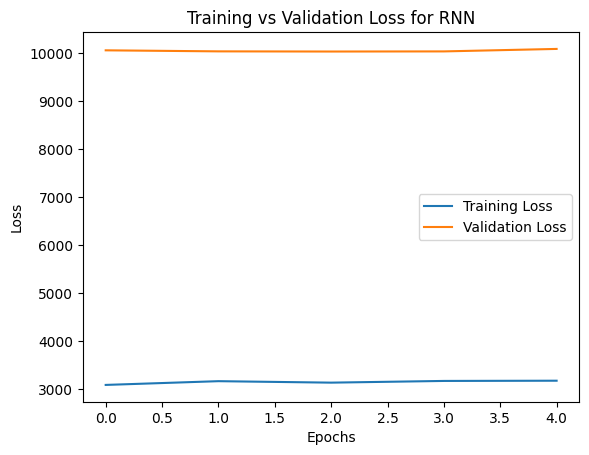

In [57]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss for RNN')
plt.show()

## Evaluate the model


In [58]:
rnn_predictions = rnn_model.predict(X_test)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)

print(f'RNN MSE: {rnn_mse}, MAE: {rnn_mae}')

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
RNN MSE: 14449.082339666349, MAE: 80.51551487065163


## visualize the model


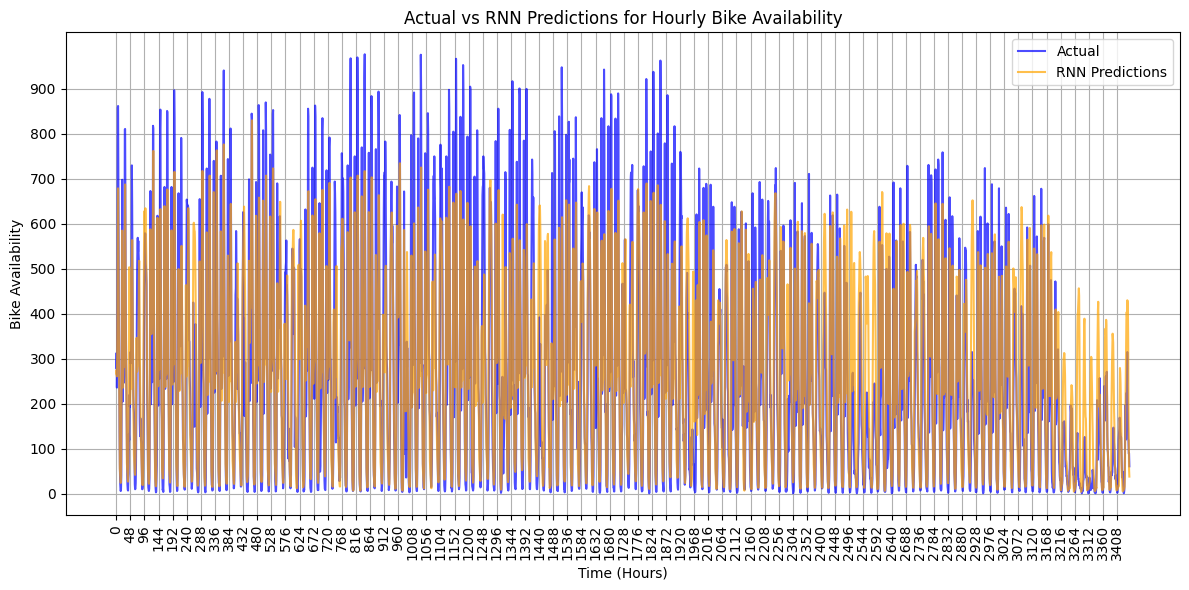

In [59]:
import matplotlib.pyplot as plt
import numpy as np

time_steps = np.arange(0, len(y_test))

plt.figure(figsize=(12, 6))

plt.plot(time_steps, y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(time_steps, rnn_predictions, label='RNN Predictions', color='orange', alpha=0.7)

# X-axis: Label every 24th hour (for daily intervals)
plt.xticks(np.arange(0, len(y_test), step=48), rotation=90)

# Y-axis:
plt.yticks(np.arange(0, 1000, step=100))

plt.grid(True)

# Add labels and title
plt.xlabel('Time (Hours)')
plt.ylabel('Bike Availability')
plt.title('Actual vs RNN Predictions for Hourly Bike Availability')

plt.legend()

plt.tight_layout()
plt.show()


## Model Evaluation summary

In [49]:
# Calculate Mean Squared Error (MSE)
mse_rnn = mean_squared_error(y_test, rnn_predictions)
print(f"RNN MSE: {mse_rnn}")

# Calculate Root Mean Squared Error (RMSE)
rmse_rnn = np.sqrt(mse_rnn)
print(f"RNN RMSE: {rmse_rnn}")

# Calculate Mean Absolute Error (MAE)
mae_rnn = mean_absolute_error(y_test, rnn_predictions)
print(f"RNN MAE: {mae_rnn}")

# Calculate R² Score
r2_rnn = r2_score(y_test, rnn_predictions)
print(f"RNN R²: {r2_rnn}")


RNN MSE: 13532.408847885135
RNN RMSE: 116.32888226010398
RNN MAE: 77.7797129370447
RNN R²: 0.7210133791727276
